In [1]:
import snpy
import numpy as np
import pandas as pd

import os
import glob

from multiprocessing import Pool

print(f'SNooPy version: v{snpy.__version__}')

SNOOPY_MODEL = 'max_model'  # max_model  EBV_model2
OUTPUT_DIR = f'fits_csp'
PROCESSES = 8

SNooPy version: v2.6.0


In [5]:
def get_parameter(sn, parameter, include_sys=False):
    """Obtains the value of the given parameter and
    the total (systematics + statistical) uncertainty
    of a fitted SN.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
    parameter: str
        Parameter to extract.
    include_sys: bool
        If `True`, systematic uncertainties are 
        included.
        
    Returns
    =======
    value: float
        Value of the parameter.
    err: float
        Total uncertainty in the parameter. 
    """
    
    value = sn.parameters[parameter]
    stats_err = sn.errors[parameter]
    if include_sys:
        sys_err = sn.systematics()[parameter]
    else:
        sys_err = 0.0
    err = np.sqrt(stats_err**2 + sys_err**2)
    
    return value, err

In [6]:
def fit_sn(sn):
    """Fits a SN with SNooPy.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.

    Returns
    =======
    sn object.
    """
    sn.fit()
    
    # save object and plot
    output_snpy = os.path.join(OUTPUT_DIR, f'{sn.name}.snpy')
    sn.save(output_snpy)
    output_plot = os.path.join(OUTPUT_DIR, f'{sn.name}.jpeg')
    sn.plot(outfile=output_plot)
    
    return sn

In [7]:
def full_fit(sn):
    """Fits a SN with `fit_sn`. The combined results 
    are saved in a single snpy file.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
        
    Results
    =======
    sn_df: pandas DataFrame
        Dataframe with the results of the SN. E.g.,
        Tmax, st, etc., for the different fits. 
    """
    
    sn = fit_sn(sn)
    
    # save results
    Tmax, Tmax_err = get_parameter(sn, 'Tmax')
    st, st_err = get_parameter(sn, 'st')
    results_dict = {'name':sn.name,
                    'z':sn.z,
                    'Tmax':Tmax,
                    'Tmax_err':Tmax_err,
                    'st':st,
                    'st_err':st_err,
                   }
    sn_df = pd.DataFrame(results_dict, index=[0])
    
    return sn_df

In [8]:
def pool_fit(sn_file):
    '''Fits a SN with SNooPy and returns the saved results.
    
    Parameters
    ==========
    sn_file: str
        SN file in SNooPy format.

    Returns
    =======
    The SN's saved results in a DataFrame, if successful.
    '''
    
    sn = snpy.import_lc(sn_file)
    sn.choose_model(SNOOPY_MODEL)
    
    if 'K' in sn.allbands():
        sn.data.pop('K')
        
    try:
        sn_df = full_fit(sn)
        return sn_df
    except Exception as message:
        print(f'Unable to fit {sn.name}: {message}')

In [11]:
sn_files = [file for file in glob.glob('csp_data/*')]

results = Pool(PROCESSES).map(pool_fit, (sn_file for sn_file in sn_files))

master_df = pd.concat(results, ignore_index=True)
master_df.to_csv(f'reference_results_csp.csv', index=False)

Unable to fit SN2014dn: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.
Unable to fit SN2006mr: All weights for filter Y are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.
Unable to fit SN2008cd: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.
Unable to fit CSP15aae: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.
Unable to fit SN2007N: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.
Unable to fit SN2007jh: All weights for filter Y are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful d

/home/tomas/anaconda3/envs/flows_sims/lib/python3.10/site-packages/snpy/model.py:310: RuntimeWarning: overflow encountered in power
  f = power(10, -0.4*(mod - self.parent.data[band].filter.zp))
/home/tomas/anaconda3/envs/flows_sims/lib/python3.10/site-packages/snpy/model.py:322: RuntimeWarning: invalid value encountered in multiply
  resids_list.append((f - self.parent.data[band].flux)*W)
/home/tomas/anaconda3/envs/flows_sims/lib/python3.10/site-packages/snpy/mangle_spectrum.py:608: RuntimeWarning: overflow encountered in power
  resps[-1].append(num.power(10, -0.4*(mags[i][j] - fset[b].zp)))


Unable to fit SN2005ke: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.


/home/tomas/anaconda3/envs/flows_sims/lib/python3.10/site-packages/snpy/model.py:313: RuntimeWarning: overflow encountered in power
  cov_f = power(f*err/1.0857,2)


Unable to fit SN2007al: index 7 is out of bounds for axis 1 with size 7
Unable to fit SN2009F: All weights for filter H are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.
Unable to fit CSP12J: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.


Update results with missing SNe

In [35]:
sn_name = 'SN2014ba'
sn = snpy.import_lc(f'csp_data/{sn_name}_snpy.txt')
sn.choose_model(SNOOPY_MODEL)

if 'K' in sn.allbands():
    sn.data.pop('K')

sn.plot()
plt.show()
sn.fit(['B'], kcorr=0)
bands2fit = ['B', 'g', 'V', 'r', 'i']
#bands2fit = ['B', 'V']
sn.fit(bands2fit)

In [38]:
sne = ['SN2014dn', 'SN2008cd', 'CSP15aae', 'SN2014ba', 'CSP12J']

['SN2014dn', 'SN2008cd', 'CSP15aae', 'SN2014ba', 'CSP12J']

SN2008cd failed!
SN2014ba failed!


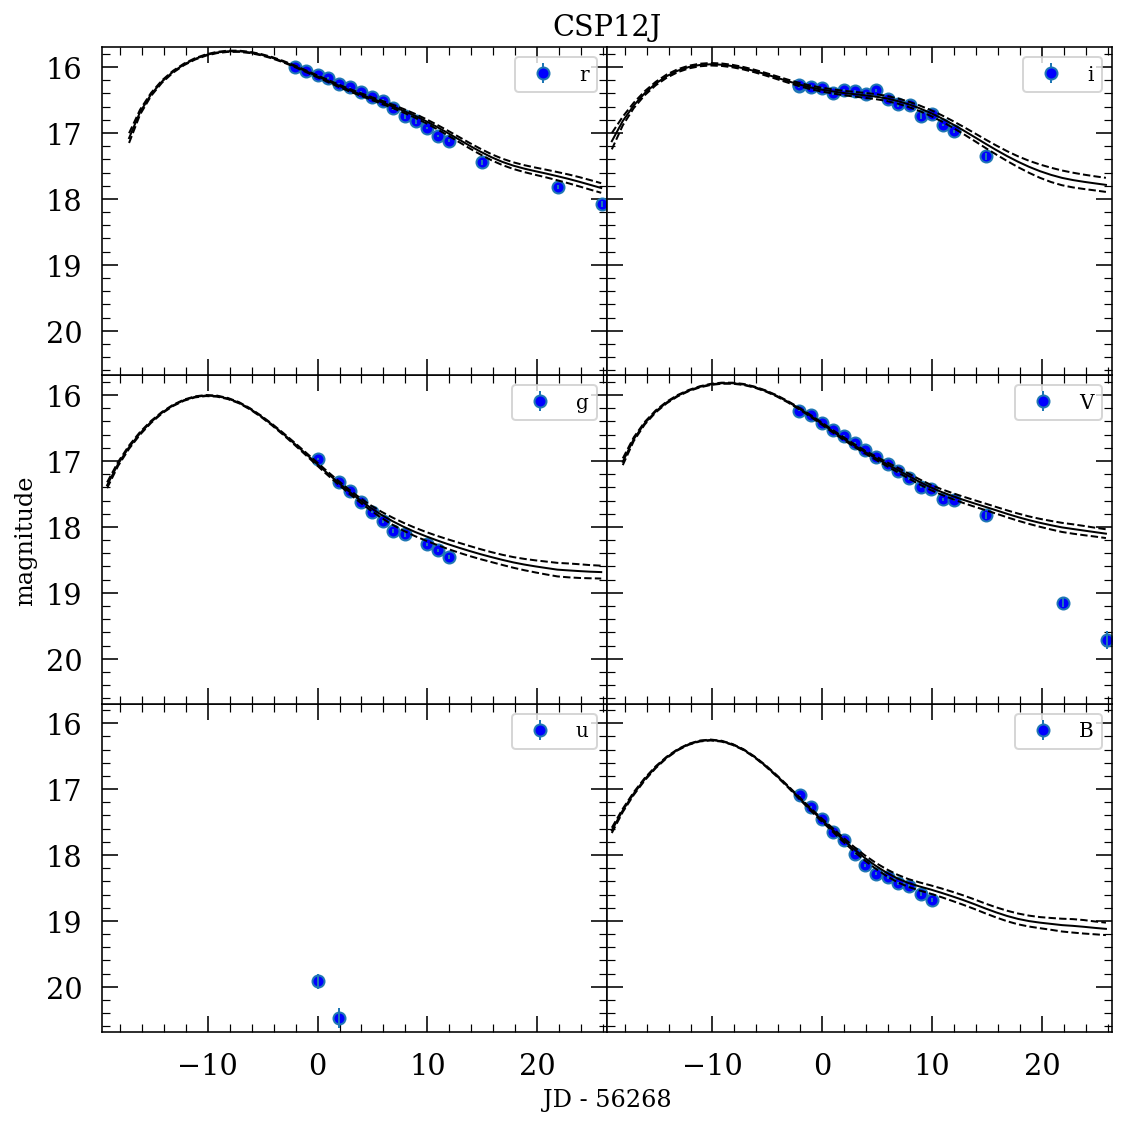

In [52]:
results_list = []

for sn_name in sne:
    sn = snpy.import_lc(f'csp_data/{sn_name}_snpy.txt')
    sn.choose_model(SNOOPY_MODEL)
    
    if 'K' in sn.allbands():
        sn.data.pop('K')
       
    try:
        bands2fit = ['B', 'g', 'V', 'r', 'i']
        # if 'SN2008cd':
        #     bands2fit
        # if 'SN2014ba':
        #     bands2fit
        sn.fit(bands2fit)
        output_snpy = os.path.join(OUTPUT_DIR, f'{sn.name}.snpy')
        sn.save(output_snpy)
        output_plot = os.path.join(OUTPUT_DIR, f'{sn.name}.jpeg')
        sn.plot(outfile=output_plot)

        Tmax, Tmax_err = get_parameter(sn, 'Tmax')
        st, st_err = get_parameter(sn, 'st')
        results_dict = {'name':sn.name,
                            'z':sn.z,
                            'Tmax':Tmax,
                            'Tmax_err':Tmax_err,
                            'st':st,
                            'st_err':st_err,
                               }
        sn_df = pd.DataFrame(results_dict, index=[0])
        results_list.append(sn_df)
    except:
        print(f'{sn_name} failed!')
    
new_df = pd.concat(results_list, ignore_index=True)

In [54]:
sne_df = pd.read_csv('reference_results_csp.csv')
sne_df = pd.concat([sne_df, new_df])

In [56]:
sne_df.to_csv(f'reference_results_csp.csv', index=False)